## Import & Data Loading 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/MIE368_Project/Data'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
listings_raw = pd.read_csv("{}/O_listings.csv".format(data_dir))
houseprice_raw = pd.read_csv("{}/properties.csv".format(data_dir))
distance_to_downtown = pd.read_csv("{}/distance_to_dt.csv".format(data_dir), header=None)
num_airbnb_nearby = pd.read_csv("{}/num_airbnb_nearby.csv".format(data_dir), header=None)
tone = pd.read_csv("{}/final_tone.csv".format(data_dir), header=None)
avg = pd.read_csv("{}/aveprice.csv".format(data_dir), header=None)
listings_raw = listings_raw.drop(columns=['room_type','id','listing_url','scrape_id','last_scraped','summary','space','experiences_offered','neighborhood_overview','notes','access','interaction','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name','host_since','host_response_rate','host_acceptance_rate','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_has_profile_pic','host_identity_verified','street','neighbourhood','neighbourhood_group_cleansed','city','state','zipcode','market','smart_location','country_code','country','is_location_exact','accommodates','beds','bed_type','square_feet','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','calendar_updated','has_availability','availability_30','availability_60','availability_90','availability_365','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','requires_license','license','jurisdiction_names','is_business_travel_ready','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_location','host_verifications','neighbourhood_cleansed'])
X_aftercleaning = pd.read_csv("{}/X_aftercleaning.csv".format(data_dir))
X_afterfeatureeng = pd.read_csv("{}/X_afterfeatureeng.csv".format(data_dir))



In [ ]:
df_dropPriceNa = listings_raw.loc[listings_raw['price']!= 'NaN']
y_price = df_dropPriceNa.price
for i in range(0,3268):
  y_price[i] = y_price[i].replace('$','')
  y_price[i] = y_price[i].replace(',','')
y_price = y_price.astype(float)
listings_raw.drop(columns='price')
listings_raw['price'] = y_price
listings_raw.price
listings_raw = listings_raw.drop(listings_raw[listings_raw['price'] >= 557].index)
listings_raw.reset_index(drop=True, inplace=True)
X_afterfeatureeng.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X_afterfeatureeng['price'] = listings_raw.price

In [ ]:
X_afterfeatureeng.price.describe()

count    3235.000000
mean      102.188253
std        72.095944
min         0.000000
25%        50.000000
50%        86.000000
75%       125.000000
max       550.000000
Name: price, dtype: float64

In [ ]:
X_afterfeatureeng.isna().sum().sum()

0

## Data Transformation & New Features

In [ ]:
def monotone_transform(X):
    X_new = X.copy()
    X_new['SQRTextra_people'] = np.sqrt(X_new['extra_people'])
    X_new['SQRTdistance_to_downtown'] = np.sqrt(X_new['distance_to_downtown'])
    
    return X_new

In [ ]:
def new_feature_combos1(X):
   
  # First, we apply the monotone transform function
  X_new = monotone_transform(X)
    
    
  # Then we add new features
  X_new['Freeparkingonpremises_*_distance_to_downtown'] = X_new.Freeparkingonpremises*X_new.distance_to_downtown #has positive correlation with price
  X_new['Apartment+bathrooms'] =  X_new.Apartment + X_new.bathrooms
  X_new['Apartment+bedrooms'] =  X_new.Apartment + X_new.bedrooms
  X_new['bathrooms**Shampoo'] = X_new.bathrooms ** X_new.Shampoo

  X_new = X_new.drop(columns = 'extra_people')

    # X_new = X_new.drop(columns = ["Freeparkingonpremises",'distance_to_downtown'] )

  return X_new

In [ ]:
X_new7 = X_afterfeatureeng.copy()
cols = ['no_alcohol','length_name', 'length_host','minimum_nights_avg_ntm','guests_included','extra_people','host_total_listings_count','Freeparkingonpremises','Heating', 'Hotwater', 'Shampoo','Coffeemaker', 'Microwave','super_strict_30', 'strict_14_with_grace_period',
       'moderate', 'flexible',  'num_airbnb_nearby', 'avgpropertyprice','response_none', 'withinanhour', 'withinafewhours', 'withinaday',
       'afewdaysormore','Agreeableness', 'Analytical', 'Anger',
       'Confident', 'Conscientiousness', 'Disgust', 'Emotional Range',
       'Extraversion', 'Joy', 'Openness', 'Sadness', 'Tentative','price','Apartment', 'House', 'Nature', 'Property_type_others', 'Vacation','Wild', 'Longtermstaysallowed','Family/kidfriendly', 'Airconditioning', 'Wifi','bathrooms', 'bedrooms','instant_bookable','distance_to_downtown','bus']
X_new7 = X_new7[cols]
y_price_new = X_afterfeatureeng['price'].copy()
y_price_new = np.sqrt(y_price_new)
X_new7.price = y_price_new
X_new7 = new_feature_combos1(X_new7)

## Final Linear Regression Model 

The train score is 0.5037681100076767 and the test score is 0.4592038794677354

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new7.drop('price',1), X_new7['price'], test_size=0.30, random_state=5)
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import precision_score, recall_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

train_score = linreg.score(X_train, y_train)
test_score = linreg.score(X_test, y_test)

print('The train score is {} and the test score is {}'.format(train_score, test_score))

betas = pd.Series(linreg.coef_, index=X_train.columns)
betas = betas.append(pd.Series({"Intercept": linreg.intercept_}))
print(betas)

The train score is 0.5037681100076767 and the test score is 0.4592038794677354
no_alcohol                                     -1.633637e+00
length_name                                    -6.050393e-02
length_host                                    -3.497904e-03
minimum_nights_avg_ntm                         -6.818441e-03
guests_included                                 2.029261e-01
host_total_listings_count                       6.027972e-03
Freeparkingonpremises                           2.569960e-01
Heating                                        -6.609343e-01
Hotwater                                       -4.478586e-01
Shampoo                                         4.451760e-01
Coffeemaker                                     5.009502e-01
Microwave                                      -5.214012e-01
super_strict_30                                -4.107825e-14
strict_14_with_grace_period                     7.800545e-02
moderate                                        5.661860e-04
flexib

In [ ]:
y=linreg.predict(X_test)**2
max(y)


634.9213487052182

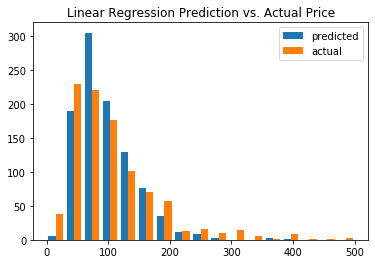

In [ ]:
bins= np.linspace(0, 500, 18)
plt.hist([linreg.predict(X_test)**2, y_test**2],bins,  label=['predicted', 'actual'])
plt.legend(loc='upper right')
plt.title("Linear Regression Prediction vs. Actual Price")
plt.show()


## Final Random Forest Model

The train score is 0.615691012502942 and the test score is 0.4964880599782881

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_new7 = X_afterfeatureeng.copy()
cols = ['no_alcohol','length_name', 'length_host','minimum_nights_avg_ntm','guests_included','extra_people','host_total_listings_count','Freeparkingonpremises','Heating', 'Hotwater', 'Shampoo','Coffeemaker', 'Microwave','super_strict_30', 'strict_14_with_grace_period',
       'moderate', 'flexible',  'num_airbnb_nearby', 'avgpropertyprice','response_none', 'withinanhour', 'withinafewhours', 'withinaday',
       'afewdaysormore','Agreeableness', 'Analytical', 'Anger',
       'Confident', 'Conscientiousness', 'Disgust', 'Emotional Range',
       'Extraversion', 'Joy', 'Openness', 'Sadness', 'Tentative','price','Apartment', 'House', 'Nature', 'Property_type_others', 'Vacation','Wild', 'Longtermstaysallowed','Family/kidfriendly', 'Airconditioning', 'Wifi','bathrooms', 'bedrooms','instant_bookable','distance_to_downtown','bus']
X_new7 = X_new7[cols]
y_price_new = X_afterfeatureeng['price'].copy()
X_new7.price = y_price_new
X_new7 = new_feature_combos1(X_new7)

#split train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new7.drop('price',1), X_new7['price'], test_size=0.30, random_state=5)


regr = RandomForestRegressor(max_depth= 8, random_state=0, n_estimators=300,min_samples_leaf=8, max_features=23)
regr.fit(X_train, y_train)

# calculate the score
train_score = regr.score(X_train, y_train)
test_score = regr.score(X_test, y_test)
print('The train score is {} and the test score is {}'.format(train_score, test_score))

# calculate betas
betas = pd.Series(regr.feature_importances_, index=X_train.columns)
# betas = betas.append(pd.Series({"Intercept": regr.intercept_}))
print(betas)


The train score is 0.615691012502942 and the test score is 0.4964880599782881
no_alcohol                                      0.000003
length_name                                     0.012028
length_host                                     0.013787
minimum_nights_avg_ntm                          0.014804
guests_included                                 0.022431
host_total_listings_count                       0.012178
Freeparkingonpremises                           0.001096
Heating                                         0.001108
Hotwater                                        0.005832
Shampoo                                         0.001499
Coffeemaker                                     0.002647
Microwave                                       0.004333
super_strict_30                                 0.000000
strict_14_with_grace_period                     0.003230
moderate                                        0.002157
flexible                                        0.002488
num_airbnb

In [ ]:
#model price < 300 seperatly 
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_300orlower = train.drop(train[train['price'] < 15].index)
train_300orlower = train_300orlower.drop(train_300orlower[train_300orlower['price'] > 225].index)
test_300orlower = test.drop(test[test['price'] < 15].index)
test_300orlower = test_300orlower.drop(test_300orlower[test_300orlower['price'] > 225].index)
X_train_300orlower = train_300orlower.drop(columns=['price'])
X_test_300orlower = test_300orlower.drop(columns=['price'])

regr.fit(X_train_300orlower,train_300orlower['price'])
train_score = regr.score(X_train_300orlower, train_300orlower['price'])
test_score = regr.score(X_test_300orlower, test_300orlower['price'])



print('The train score is {} and the test score is {}'.format(train_score, test_score))



The train score is 0.6549351905689322 and the test score is 0.537848548873871


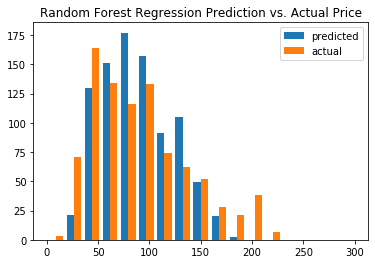

In [ ]:
bins= np.linspace(0, 300, 18)
plt.hist([regr.predict(X_test_300orlower), test_300orlower['price']], bins, label=['predicted', 'actual'])
plt.legend(loc='upper right')
plt.title("Random Forest Regression Prediction vs. Actual Price")
plt.show()


In [ ]:
X_new7.columns

Index(['no_alcohol', 'length_name', 'length_host', 'minimum_nights_avg_ntm',
       'guests_included', 'host_total_listings_count', 'Freeparkingonpremises',
       'Heating', 'Hotwater', 'Shampoo', 'Coffeemaker', 'Microwave',
       'super_strict_30', 'strict_14_with_grace_period', 'moderate',
       'flexible', 'num_airbnb_nearby', 'avgpropertyprice', 'response_none',
       'withinanhour', 'withinafewhours', 'withinaday', 'afewdaysormore',
       'Agreeableness', 'Analytical', 'Anger', 'Confident',
       'Conscientiousness', 'Disgust', 'Emotional Range', 'Extraversion',
       'Joy', 'Openness', 'Sadness', 'Tentative', 'price', 'Apartment',
       'House', 'Nature', 'Property_type_others', 'Vacation', 'Wild',
       'Longtermstaysallowed', 'Family/kidfriendly', 'Airconditioning', 'Wifi',
       'bathrooms', 'bedrooms', 'instant_bookable', 'distance_to_downtown',
       'bus', 'SQRTextra_people', 'SQRTdistance_to_downtown',
       'Freeparkingonpremises_*_distance_to_downtown', 'Apar

## Final XGBoost Model

Training r2: 0.678590212825863
Validation r2: 0.5508720230765136

In [ ]:
import xgboost as xgb

X_new7 = X_afterfeatureeng.copy()
cols = ['no_alcohol','length_name', 'length_host','minimum_nights_avg_ntm','guests_included','extra_people','host_total_listings_count','Freeparkingonpremises','Heating', 'Hotwater', 'Shampoo','Coffeemaker', 'Microwave','super_strict_30', 'strict_14_with_grace_period',
       'moderate', 'flexible',  'num_airbnb_nearby', 'avgpropertyprice','response_none', 'withinanhour', 'withinafewhours', 'withinaday',
       'afewdaysormore','Agreeableness', 'Analytical', 'Anger',
       'Confident', 'Conscientiousness', 'Disgust', 'Emotional Range',
       'Extraversion', 'Joy', 'Openness', 'Sadness', 'Tentative','price','Apartment', 'House', 'Nature', 'Property_type_others', 'Vacation','Wild', 'Longtermstaysallowed','Family/kidfriendly', 'Airconditioning', 'Wifi','bathrooms', 'bedrooms','instant_bookable','distance_to_downtown','bus']
X_new7 = X_new7[cols]
y_price_new = X_afterfeatureeng['price'].copy()
X_new7.price = np.sqrt(y_price_new)
X_new7 = new_feature_combos1(X_new7)

#split train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new7.drop('price',1), X_new7['price'], test_size=0.30, random_state=5)

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)
 
# Printing the results
print("\nTraining r2:", (xgb_reg.score(X_train, y_train)))
print("Validation r2:", (xgb_reg.score(X_test, y_test)))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:28:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Training r2: 0.678590212825863
Validation r2: 0.5508720230765136


In [ ]:

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_300orlower = train.drop(train[train['price'] < 4].index)
train_300orlower = train_300orlower.drop(train_300orlower[train_300orlower['price'] > 18.5].index)
test_300orlower = test.drop(test[test['price'] < 4].index)
test_300orlower = test_300orlower.drop(test_300orlower[test_300orlower['price'] > 18.5].index)
X_train_300orlower = train_300orlower.drop(columns=['price'])
X_test_300orlower = test_300orlower.drop(columns=['price'])

xgb_reg.fit(X_train_300orlower,train_300orlower['price'])
train_score = xgb_reg.score(X_train_300orlower, train_300orlower['price'])
test_score = xgb_reg.score(X_test_300orlower, test_300orlower['price'])



print('The train score is {} and the test score is {}'.format(train_score, test_score))



In [ ]:
bins= np.linspace(0, 300, 18)
plt.hist([xgb_reg.predict(X_train)**2, train_300orlower['price']**2],bins = 18,  label=['predicted', 'actual'])
plt.legend(loc='upper right')
plt.title("XGB_Regression prediction vs actual price (16~342)")
plt.show()

In [ ]:

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_300orlower = train.drop(train[train['price'] < 0].index)
train_300orlower = train_300orlower.drop(train_300orlower[train_300orlower['price'] >10].index)
test_300orlower = test.drop(test[test['price'] < 0].index)
test_300orlower = test_300orlower.drop(test_300orlower[test_300orlower['price'] > 10].index)
X_train_300orlower = train_300orlower.drop(columns=['price'])
X_test_300orlower = test_300orlower.drop(columns=['price'])

xgb_reg.fit(X_train_300orlower,train_300orlower['price'])
train_score = xgb_reg.score(X_train_300orlower, train_300orlower['price'])
test_score = xgb_reg.score(X_test_300orlower, test_300orlower['price'])



print('The train score is {} and the test score is {}'.format(train_score, test_score))


In [ ]:
# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()


In [ ]:

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_300orlower = train.drop(train[train['price'] < 10].index)
train_300orlower = train_300orlower.drop(train_300orlower[train_300orlower['price'] > 15].index)
test_300orlower = test.drop(test[test['price'] < 10].index)
test_300orlower = test_300orlower.drop(test_300orlower[test_300orlower['price'] > 15].index)
X_train_300orlower = train_300orlower.drop(columns=['price'])
X_test_300orlower = test_300orlower.drop(columns=['price'])

xgb_reg.fit(X_train_300orlower,train_300orlower['price'])
train_score = xgb_reg.score(X_train_300orlower, train_300orlower['price'])
test_score = xgb_reg.score(X_test_300orlower, test_300orlower['price'])



print('The train score is {} and the test score is {}'.format(train_score, test_score))

In [ ]:
# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()


In [ ]:
plt.hist(regr.predict(X_train), bins = 15)

In [ ]:
train_300orlower['price']

In [ ]:

plt.hist([linreg.predict(X_train), train_300orlower['price']],bins = 15,  label=['predicted', 'actual'])
plt.legend(loc='upper right')
plt.title("Linear Regression predic")
plt.show()


In [ ]:
train_300orlower.price.hist()